In [43]:
using KnetLayers, Random, Plots, DataFrames, StatsPlots, Query, PlotThemes, CSV
import KnetLayers: IndexedDict, arrtype, nllmask
setoptim!(M, optimizer) = for p in params(M); p.opt = deepcopy(optimizer); end
gpu(0)
KnetLayers.gc()

┌ Info: Recompiling stale cache file /home/gridsan/eakyurek/.julia/compiled/v1.2/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1240


In [44]:
gr()
theme(:ggplot2)
ENV["COLUMNS"] = 500
ENV["LINES"]   = 100

100

In [5]:
vocab    = IndexedDict([collect('0':'9'); collect('a':'z')])
digits   = '0':2:'8'
chars    = 'a':'h'
holdout  = ['0' .* ('a':'b'); '2'.*('c':'d'); '4'.*('e':'f'); '8'.*('g':'h'); "6h"]
data     = [d*c for d in digits, c in chars if d*c ∉ holdout ]

31-element Array{String,1}:
 "2a"
 "4a"
 "6a"
 "8a"
 "2b"
 "4b"
 "6b"
 "8b"
 "0c"
 "4c"
 "6c"
 "8c"
 "0d"
 "4d"
 "6d"
 "8d"
 "0e"
 "2e"
 "6e"
 "8e"
 "0f"
 "2f"
 "6f"
 "8f"
 "0g"
 "2g"
 "4g"
 "6g"
 "0h"
 "2h"
 "4h"

In [6]:
𝑿 = [vocab[collect(d)] for d in data]
V = length(vocab)

36

In [7]:
# interact(e,h,W)     = softmax(sum(e .* (W * h), dims=1))
interact(e,h,W)     = softmax(e .* (W * h))
drop(x)             = dropout(x, 0.5)
function attend(e,h,W,layer) 
    α = interact(e,h,W)
    layer(sum(drop(α .* h), dims=2)), α 
end
function encode(model, xi, 𝑿╲i=nothing)
    e   = drop(vec(model.encoder(xi))) # 2H
    if isnothing(𝑿╲i)
        model.Wμ(e), model.Wσ(e), nothing
    else          
        h          = drop(mat(model.encoder(𝑿╲i))) # H x 2 x (T-1)
        μ, αμ      = attend(e,h,model.Wμa.weight,model.Wμ)
        logσ², ασ  = attend(e,h,model.Wσa.weight,model.Wσ)
        μ, logσ², (αμ=αμ,ασ=ασ)
    end 
end

function decode(model, zi, 𝑿╲i=nothing)
    if !isnothing(𝑿╲i)
        h      = mat(drop(model.encoder(𝑿╲i)))  # H x 2 x (T-1)
        zi, αz = attend(zi,h,model.Wza.weight,model.Wz)
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2)), αz
    else
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2)), nothing
    end
end
    

isencatt(model)    = haskey(model, :Wμa) &&  haskey(model, :Wσa) 
isdecatt(model)    = haskey(model, :Wza) 
hiddensize(model)  = size(model.encoder.weight,1)
elementtype(model) = eltype(model.encoder.weight)

elementtype (generic function with 1 method)

In [8]:
function loss(model, xi, 𝑿╲i; encatt=false, decatt=false, results=false)
    μ, logσ², αe =  encode(model, xi, (encatt ? 𝑿╲i : nothing))
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    xp, αd = decode(model, z, (decatt ? 𝑿╲i : nothing))
    KL = -sum(1 .+ logσ² .- μ.^2 .- σ²)/ 2length(μ)
    L  = nll(xp,xi) + KL
    if results
        L, greedy(xp), (αe=αe, αd=αd)
    else
        L
    end
end

function eval(model, vocab, 𝑿)
    results  = Dict()
    for i=1:length(𝑿)
        xi  = 𝑿[i]
        𝑿╲i = hcat([𝑿[1:i-1]; 𝑿[i+1:end]]...)
        L, y, att = loss(model, xi,  𝑿╲i; encatt=isencatt(model), decatt=isdecatt(model), results=true)
        results[xi] = (L=L,y=y,att=att)
    end
    decres = empty(results)
    for (k,v) in results
        decres[join(vocab[k])] = (L=v.L,y=join(vocab[v.y]), att = v.att)
    end
    return decres
end

function train!(model, 𝑿; epoch=20, optim=Adam())
    setoptim!(model,optim)
    for i=1:epoch
        lss, cnt= 0.,0.
        for (i,xi) in enumerate(shuffle(𝑿))
            xi   = 𝑿[i]
            𝑿╲i = hcat([𝑿[1:i-1]; 𝑿[i+1:end] ]...)
            J = @diff loss(model, xi, 𝑿╲i, encatt=isencatt(model), decatt=isdecatt(model))
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end            
            lss += value(J)
            cnt += 1
        end
    end
end

train! (generic function with 1 method)

In [9]:
function samplingparams(model, 𝑿; useprior=false)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,2H,1)), arrtype(ones(T,2H,1))
    else
        μ, σ² = arrtype(zeros(T,2H,1)), arrtype(zeros(T,2H,1))
        for i=1:length(𝑿)
            xi  = 𝑿[i]
            𝑿╲i = hcat([𝑿[1:i-1];𝑿[i+1:end]]...)
            μi, logσ²,_ =  encode(model, xi,  isencatt(model) ? 𝑿╲i : nothing)
            μ  .+= μi
            σ² .+= exp.(logσ²)
        end
        μ/length(𝑿),  σ²/length(𝑿)
    end
end

function sample(model, vocab, 𝑿; N=100, useprior=false)
    μ, σ² =  samplingparams(model,𝑿; useprior=useprior) 
    σ  = sqrt.(σ²)
    𝑿 =  hcat(𝑿...)
    samples = []
    for i=1:N
        z     = μ .+ randn!(similar(μ)) .* σ
        xp, _ = decode(model, z, (isdecatt(model) ? 𝑿 : nothing))
        push!(samples,join(vocab[greedy(xp)]))
    end
    return samples
end

sample (generic function with 1 method)

In [10]:
# interact(e,h,W)     = softmax(sum(e .* (W * h), dims=1))
# interact_b(e,h,mask::Nothing) = softmax(e .* h, dims=(1,2))
# drop(x) = dropout(x, 0.5)
function interact(e, h; mask=nothing, sumout=false)
    y = isnothing(mask) ?  (e .* h) : ( e .* h .+ mask)
    if sumout
        α = softmax(mat(sum(y,dims=1)),dims=1)
        reshape(α,1,size(α)...)
    else
        softmax(y, dims=(1,2))
    end
end

function attend(e, h, W, layer, mask=nothing; sumout=false) 
    h3d = reshape(W*h, size(h,1),size(h,2),1)
    h   = reshape(h, size(h,1),size(h,2),1)
    α   = interact(e,h3d; mask=mask, sumout=sumout)  
    layer(mat(sum(drop(α .* h), dims=2))), α 
end

function encode(model, xi, 𝑿=nothing, mask=nothing)
    e = drop(model.encoder(xi))
    H,N,B = size(e)
    if isnothing(𝑿)
        e = reshape(e,H*N,B)
        model.Wμ(e), model.Wσ(e), nothing
    else   
        e = reshape(e,H*N,1,B)
        h  = drop(mat(model.encoder(𝑿))) # 2H x  L
        μ, αμ    = attend(e,h,model.Wμa.weight,model.Wμ, mask)
        logσ², ασ = attend(e,h,model.Wσa.weight,model.Wσ, mask)
        μ, logσ², (αμ=αμ,ασ=ασ)
    end 
end

function decode(model, zi, 𝑿=nothing, mask=nothing)
    if !isnothing(𝑿)
        h      = mat(drop(model.encoder(𝑿)))  # 2H x B
        zi     = reshape(zi,size(zi,1),1,size(zi,2))
        zi, αz = attend(zi,h,model.Wza.weight,model.Wz, mask)
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2,size(zi,2))), αz
    else
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2,size(zi,2))), nothing
    end
end


function loss(model, xi, 𝑿; mask=nothing, encatt=false, decatt=false, results=false)
    μ, logσ², αe =  encode(model, xi, (encatt ? 𝑿 : nothing), mask)
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    xp, αd = decode(model, z, (decatt ? 𝑿 : nothing), mask)
    KL = -sum(1.0f0 .+ logσ² .- μ.^2 .- σ²) / 2length(μ)
    L  = nllmask(xp,xi) + KL
    if results
        L, greedy(xp), (αe=αe, αd=αd)
    else
        L
    end
end


function get_mask(indices,L)
    B = length(indices)
    mask = zeros(Float32,1,L,B)
    for (i,ind) in enumerate(indices)
        mask[1,ind,i] = -1.0f30
    end
    return arrtype(mask)
end
    

batches(X,B) = [collect(i:i+B-1) for i=1:B:length(X)-B+1]

    
function train!(model, 𝑿; epoch=20, optim=Adam(), B=2)
    setoptim!(model,optim)
    for i=1:epoch
        lss, cnt= 0.,0.
        X = shuffle(𝑿)
        for (i,indices) in enumerate(batches(X,B))
            xi   = hcat(X[indices]...)
            xt   = hcat(X...)
            mask = get_mask(indices,length(X))
            J = @diff loss(model, xi, xt, mask=mask, encatt=isencatt(model), decatt=isdecatt(model))
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end            
            lss += value(J)
            cnt += 1
        end
    end
end

train! (generic function with 1 method)

In [12]:
function get_vae_models(H=256)
    encoder    = Embed(input=V,output=H)
    decoder    = Embed(input=H,output=V)
    Wμa        = Multiply(input=2H,output=2H)
    Wμ         = Dense(input=2H,output=2H, activation=ELU())
    Wza        = Multiply(input=2H,output=2H)
    Wz         = Dense(input=2H,output=2H, activation=ELU())
    Wσa        = Multiply(input=2H,output=2H)
    Wσ         = Dense(input=2H,output=2H, activation=ELU())
    model_atte = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσa=Wσa, Wσ=Wσ, decoder=decoder)
    model_vae  = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσ=Wσ, decoder=decoder)
    model_attd = (encoder=encoder, Wμ=Wμ, Wσ=Wσ, Wza=Wza, Wz=Wz, decoder=decoder)
    model_attde = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσa=Wσa, Wσ=Wσ, Wza=Wza, Wz=Wz, decoder=decoder)
    (model_vae, model_atte, model_attd, model_attde);
end

get_vae_models (generic function with 2 methods)

In [13]:
function samplingparams(model, 𝑿; useprior=false, B=2)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,2H,1)), arrtype(ones(T,2H,1))
    else
        μ, σ² = arrtype(zeros(T,2H,1)), arrtype(zeros(T,2H,1))
        for (i,indices) in enumerate(batches(𝑿,B))
            xi   = hcat(𝑿[indices]...)
            xt   = hcat(𝑿...)
            mask = get_mask(indices,length(𝑿))
            μi, logσ²,_ =  encode(model, xi,  isencatt(model) ? xt : nothing, mask)
            μ  .+= sum(μi,dims=2)
            σ² .+= sum(exp.(logσ²),dims=2)
        end
        μ/length(𝑿),  σ²/length(𝑿)
    end
end

greedy(y) = mapslices(argmax, y, dims=1)
function sample(model, vocab, 𝑿; N=100, useprior=false)
    μ, σ² =  samplingparams(model,𝑿; useprior=useprior) 
    xt    =  hcat(𝑿...)
    r     =  similar(μ,size(μ,1),N)
    z     =  μ .+ randn!(r) .* sqrt.(σ²)
    xp, _ =  decode(model, z, (isdecatt(model) ? xt : nothing),  nothing)
    vec(mapslices(x->join(vocab[greedy(x)]), convert(Array, xp), dims=(1,2)))
end

sample (generic function with 1 method)

In [14]:
cmodel = get_vae_models(256)[2]
train!(cmodel, 𝑿; epoch=30, optim=Adam(),B=2)
sampled = sample(cmodel, vocab, 𝑿; N=100)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]   
unique(unseen)
# push!(df2, (isencatt(cmodel), isdecatt(cmodel), H, opt.lr, "$opt", epoch,  length(unseen), length(holdout)-length(unique(unseen)), length(wrong),length(unique(unseen)) ))
# print((row+=1), " ")

7-element Array{String,1}:
 "0a"
 "8g"
 "6h"
 "0b"
 "2d"
 "4e"
 "4f"

In [11]:
sampled = sample(cmodel, vocab, 𝑿; N=100, useprior=true)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]   
unique(unseen)

UndefVarError: UndefVarError: cmodel not defined

In [12]:
plot(Array(μ))

UndefVarError: UndefVarError: μ not defined

In [13]:
function probmap(y)
    u=unique(y)
    Dict([(i,count(x->x==i,y) / length(y)) for i in u])
end

probmap (generic function with 1 method)

In [153]:
df2 = DataFrame(EncoderAtt = Bool[], DecoderAtt = Bool[], B=Int[], H = Int[], lr=Float64[], Optimizer = String[], Epoch = Int[], UnseenCnt=Int[], MissedClass=Int[], WrongCount=Int[])

,EncoderAtt,DecoderAtt,B,H,lr,Optimizer,Epoch,UnseenCnt,MissedClass,WrongCount
,Bool,Bool,Int64,Int64,Float64,String,Int64,Int64,Int64,Int64


In [ ]:
row = 0
for H in (256,128)
    for opt in (Adam, Rmsprop, SGD)
        for lr in (0.001, 0.01, 0.1, 1.0)
            for B in (1,2,4,8,16)
                for epoch in (10,20,30)
                    for model in get_vae_models(H)
                        cmodel = deepcopy(model)
                        train!(cmodel, 𝑿; epoch=epoch, optim=opt(lr=lr))
                        sampled = sample(cmodel, vocab, 𝑿; N=100)
                        unseen = [s for s in sampled if s ∈ holdout]
                        wrong  = [s for s in sampled if s ∉ [data;holdout]]              
                        push!(df2, (isencatt(cmodel), isdecatt(cmodel), B, H, lr, "$opt", epoch,  length(unseen), length(holdout)-length(unique(unseen)), length(wrong)))
                        print((row+=1), " ")
                    end
                end
           end
        end
    end
end
df2[!,:UnseenClass] = length(holdout) .- df2.MissedClass;

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 

In [17]:
df2[!,:UnseenClass] = length(holdout) .- df2.MissedClass;

In [157]:
df3 = df2 |> @orderby_descending(_.UnseenClass) |> @thenby(_.WrongCount) |> DataFrame

,EncoderAtt,DecoderAtt,B,H,lr,Optimizer,Epoch,UnseenCnt,MissedClass,WrongCount,UnseenClass
,Bool,Bool,Int64,Int64,Float64,String,Int64,Int64,Int64,Int64,Int64
1,0,0,4,256,0.001,Rmsprop,20,23,0,0,9
2,1,0,1,256,0.01,Rmsprop,20,21,0,0,9
3,1,0,4,256,0.01,Rmsprop,10,27,0,0,9
4,1,0,2,128,0.01,Rmsprop,10,20,0,0,9
5,1,0,16,128,0.01,Rmsprop,30,26,0,0,9
6,1,0,2,128,0.1,SGD,20,18,0,0,9
7,0,0,8,256,0.001,Adam,10,23,0,1,9
8,1,0,2,256,0.01,Adam,30,20,0,1,9
9,1,0,4,256,0.01,Adam,20,23,0,1,9


In [166]:
cmodel = get_vae_models(128)[2]
train!(cmodel, 𝑿; epoch=60, optim=Adam())
sampled = sample(cmodel, vocab, 𝑿; N=100)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]
result = eval(cmodel, vocab, 𝑿)

┌ Info: Building the CUDAnative run-time library for your sm_70 device, this might take a while...
└ @ CUDAnative /home/gridsan/eakyurek/.julia/packages/CUDAnative/Lr0yj/src/compiler/rtlib.jl:173


BoundsError: BoundsError: attempt to access (128, 2)
  at index [3]

In [148]:
unique(unseen)

6-element Array{String,1}:
 "8g"
 "4e"
 "4f"
 "2d"
 "0b"
 "2c"

In [150]:
for (k,v) in result
    if k==v.y
        println(v)
    end
end

(L = 0.92936647f0, y = "6d", att = (αe = (αμ = K32(256,30)[1.9662112e-7⋯], ασ = K32(256,30)[4.431309e-7⋯]), αd = nothing))
(L = 0.8953346f0, y = "4c", att = (αe = (αμ = K32(256,30)[1.828638e-5⋯], ασ = K32(256,30)[4.588832e-5⋯]), αd = nothing))


In [152]:
inp = "4h"
v = result[inp]
StatsPlots.bar(v.y, sum(v.att.αe.αμ, dims=1), xticks=(0.5:1:length(v[2])-0.5, v[2]), title="$inp->$(v[1])", size=(1200,300))

ErrorException: Cannot convert String to series data for plotting

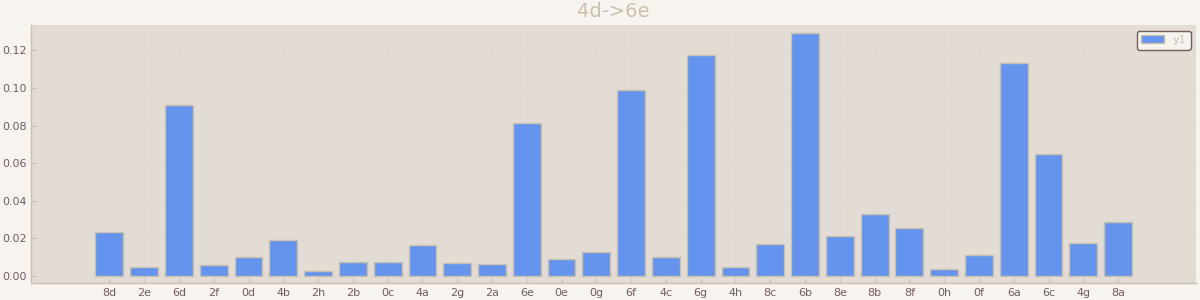

In [41]:
inp = "4d"
v = d[inp]
StatsPlots.bar(1:length(v[4]), v[3], xticks=(1:length(v[2]), v[2]), title="$inp->$(v[1])", size=(1200,300))

In [ ]:
df2 |> @orderby_descending(_.UnseenClass) |> @thenby(_.WrongCount) |> DataFrame

In [ ]:
bestmodels = df2 |>  @filter(_.Epoch==20 && _.Optimizer == "Rmsprop" && _.lr==0.001) |> DataFrame
@df bestmodels groupedbar(:H, :UnseenClass , group = {Enc_Att = :EncoderAtt, Dec_Att  = :DecoderAtt}, xlabel = "Models", ylabel = "# of Unseen Classes", title = "# of Unseen Classes vs Epoch on Different Models")

In [ ]:
bestmodels = df2 |>  @filter(_.Epoch==20 && _.Optimizer == "Rmsprop" && _.lr==0.001) |> DataFrame
@df bestmodels groupedbar(:H, :WrongCount , group = {Enc_Att = :EncoderAtt, Dec_Att  = :DecoderAtt}, xlabel = "Models", ylabel = "# of Unseen Classes", title = "# of Unseen Classes vs Epoch on Different Models")

In [ ]:
E = 64
H = 256

In [ ]:
lmmodel = (rnn=LSTM(input=V,hidden=H,embed=E,dropout=0.5), output=Linear(input=H,output=V))

In [ ]:
train!(lmmodel,x_onehot; optim=Adam(lr=0.01))

In [ ]:
loss(lmmodel,x_onehot[1])

In [ ]:
sampled =[vocab[predict(lmmodel,2)] for i=1:100];

In [ ]:
unseen = [join(s) for s in sampled if join(s) ∈ holdout]
wrong  = [join(s) for s in sampled if join(s) ∉ [data;holdout]]
dkl = KLDivergence(data,holdout,sampled)               

In [ ]:
unseen

# Morph Data

In [220]:
using KnetLayers, Plots
import KnetLayers: nllmask, arrtype
setoptim!(M, optimizer) = for p in params(M); p.opt = deepcopy(optimizer); end
gpu(0)
KnetLayers.gc()
include("parser.jl")
download(SIGDataSet)
ENV["LINES"]   = 50

50

In [221]:
data  = map(parseDataLine, eachline("./data/Sigmorphon/task1/all/spanish-train-high"));
vocab = Vocabulary(data)
edata = encode(data,vocab);
test  = map(parseDataLine, eachline("./data/Sigmorphon/task1/all/spanish-test"));
tdata = encode(test,vocab);

In [222]:
vocab.chars

IndexedDict{Char}(Dict('n' => 5,'f' => 33,'á' => 22,'w' => 38,'d' => 26,'e' => 9,'o' => 6,'ñ' => 29,'🎬' => 4,'ú' => 20…), ['❓', '⭕', '🏁', '🎬', 'n', 'o', ' ', 'r', 'e', 'i'  …  'ñ', 'x', 'é', 'v', 'f', 'ó', 'y', 'ü', 'k', 'w'])

In [223]:
trainsfs = unique(map(x->join(x.surface),data))
testsfs =  unique(map(x->join(x.surface),test)) 

1000-element Array{String,1}:
 "no viralice"   
 "trapeé"        
 "se preciaron"  
 "sacudiría"     
 "amputó"        
 "arrasan"       
 "mayaba"        
 "espacien"      
 "retransmitiere"
 "no evidencies" 
 "pinchare"      
 "facilitas"     
 "guacarearon"   
 "confluyereis"  
 "trabo"         
 "acantonaría"   
 "instrumentadas"
 "desnataren"    
 "customizad"    
 "enmascarado"   
 "derruya"       
 "conminen"      
 "ramificarais"  
 ⋮               
 "generalicemos" 
 "desescombraras"
 "independizado" 
 "enlistado"     
 "apuran"        
 "encuadernare"  
 "se acobardó"   
 "petamos"       
 "segará"        
 "reunieron"     
 "finalizaréis"  
 "citado"        
 "versifique"    
 "manipulareis"  
 "mangonearán"   
 "abrocharéis"   
 "batisteis"     
 "entrecierra"   
 "transmigres"   
 "exculparían"   
 "escanees"      
 "cuadriplicó"   

In [224]:
vocab.specialIndices

(unk = 1, mask = 2, eow = 3, bow = 4)

In [225]:
drop(x) = dropout(x, 0.3)
function interact(e, h; sumout=false)
    y = e .* h
    if sumout
        α = softmax(mat(sum(y,dims=1)),dims=1)
        reshape(α,1,size(α)...)
    else
        softmax(y, dims=(1,2))
    end
end

function attend(ea,  h, W, layer; sumout=false) 
    α   = interact(ea,W(h); sumout=sumout)  
    layer(mat(sum(drop(α .* h), dims=2))), α 
end
function encode(morph, xi, xt) 
    e     = morph.encoder(xi.tokens; batchSizes=xi.batchSizes, hy=true).hidden
    H,B,_ = size(e)
    h     = reshape(cat1d((morph.encoder(ex.tokens; batchSizes=ex.batchSizes, hy=true).hidden for ex  in xt)...), H, 2morph.num, B)
    μ, αu = attend(reshape(morph.Weaμ(e),H,1,B), h, morph.Wμa, morph.Wμ; sumout=false) 
    logσ², ασ = attend(reshape(morph.Weaσ(e),H,1,B), h, morph.Wσa,  morph.Wσ; sumout=false)    
    return μ, logσ², (αu=αu,ασ=ασ)
end

function decode(morph, z, xi=nothing; bow=4, maxL=20)
    if isnothing(xi)
         B      = size(z,2)
         H      = hiddensize(morph)
         input  = fill!(Vector{Int}(undef,B),bow)
         #y      = morph.decoder(input;batchSizes=[B]).y
         preds  = zeros(Int,B,maxL)
         h,c = z, zero.(z)
         for i=1:maxL
            out      = morph.decoder(input,h,c;batchSizes=[B], hy=true, cy=true)
            h,c = out.hidden, out.memory          
            input  = vec(mapslices(x->catsample(softmax(x)), convert(Array,morph.output(out.y)), dims=1))
            preds[:,i] = input
         end
        return preds
    else
        x = pad_packed_sequence(xi, bow, toend=false)
        y = morph.decoder(x.tokens, reshape(z,size(z)...,1); batchSizes=x.batchSizes).y
        morph.output(y)
    end
end

function loss(morph, vocab, xi, x; λ=0.0)
    μ, logσ², _ =  encode(morph, xi,x)
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    y  = decode(morph, z, xi; bow=vocab.specialIndices.bow)
    KL = -sum(1.0f0 .+ logσ² .- μ.^2 .- σ²) / 2length(μ)
    yt  = pad_packed_sequence(xi, vocab.specialIndices.eow)
    L  = KnetLayers.nllmask(y,yt.tokens) + λ * KL
end

function attentions(model, data, vocab;  B=16)
    edata = Iterators.Stateful(data)
    attentions = []
    while ((d = getbatch(edata,B)) !== nothing)
        xi,xt = d
        μ,logσ²,αs = encode(model, xi, xt)
        sfs = map(inds -> xi.tokens[inds],_batchSizes2indices(xi.batchSizes))
        exs = [map(inds -> x.tokens[inds],_batchSizes2indices(x.batchSizes)) for x in xt]
        push!(attentions, (sfs,exs,map(Array,αs)))
    end
    return attentions
end

function train!(model, data, vocab; epoch=20, optim=Adam(), B=16, λrate = 1/1000 )
    setoptim!(model,optim)
    λ = 1.0
    for i=1:epoch
        lss = 0.0
        cnt = 0
        edata = Iterators.Stateful(data)
        while ((d = getbatch(edata,B)) !== nothing)
            J = @diff loss(model ,vocab, d...;λ=λ)
            lss += value(J)
            cnt += 1
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end
        end
        println(lss/cnt)
    end
end

hiddensize(model)  = encoder.specs.hiddenSize
elementtype(model) = eltype(model.encoder.params)

function samplingparams(model, data; useprior=false, B=16)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,H,1)), arrtype(ones(T,H,1))
    else
        μ, σ² = arrtype(zeros(T,H,1)), arrtype(zeros(T,H,1))
        cnt = 0
        edata = Iterators.Stateful(data)
        while ((d = getbatch(edata,B)) !== nothing)
            μi, logσ² = encode(model, d...)
            μ  .+= sum(μi,dims=2)
            σ² .+= sum(exp.(logσ²),dims=2)
            cnt += 1
        end
        μ/cnt, σ²/cnt
    end
end

greedy(y) = mapslices(argmax, y, dims=1)
function trim(chars::Vector{Int},vocab)
    out = Int[]
    for c in chars
        c == vocab.specialIndices.eow && break
        if c ∉ vocab.specialIndices
            push!(out,c)
        end
    end
    return join(vocab.chars[out])
    end 

function sample(model, vocab, data; N=5, useprior=false)
    μ, σ² =  samplingparams(model, data; useprior=useprior) 
    samples = []
    for i = 1 : (N ÷ 5) +1
        r     =  similar(μ,size(μ,1),5)
        z     =  μ .+ randn!(r) .* sqrt.(σ²)
        y     = decode(model, z)
        s     = mapslices(x->trim(x,vocab),y, dims=2)
        push!(samples,s)
    end
    cat1d(samples...)
end

function catsample(p)
    r = rand()
    for c = 1:length(p)
        r -= p[c]
        r < 0 && return c
    end
    
end

catsample (generic function with 1 method)

In [226]:
H=512
E=128
V=length(vocab.chars)
encoder = LSTM(input=V,hidden=H,embed=E,dropout=0.3)
decoder = LSTM(input=V,hidden=H,embed=E,dropout=0.3)
decoder.embedding = encoder.embedding
morph = (encoder=encoder,
         Wμ=MLP(H,H,H, activation=Tanh()), 
         Wσ=MLP(H,H,H, activation=Tanh()), 
         Weaμ=Multiply(input=H, output=H),
         Weaσ=Multiply(input=H, output=H),
         Wμa=Multiply(input=H, output=H), 
         Wσa=Multiply(input=H, output=H),
         output=Linear(input=H,output=V), 
         decoder = decoder, 
         num=edata.num)
train!(morph, edata, vocab; optim=Adam(), epoch=30)

2.1497849525293744
1.76964672601372
1.6852867977980293
1.5988201742304955
1.5129492849426112
1.4262491313421983
1.3440428750794264
1.268919750915817
1.2018812495973368
1.1409334288551065
1.086325445798767
1.0420982188073802
1.008205027415062
0.9838466062018765
0.966398172309075
0.9487767411171866
0.9330511933676607
0.9182144466122089
0.90654075805209
0.8935091253168357
0.8829627912385623
0.877599291314662
0.8709365196763654
0.8671383793702174
0.863075113719434
0.8566398145610176
0.8537189716255816
0.8544000424520171
0.8511666156408842
0.8456175854082568


In [227]:
samples = unique(sample(morph, vocab, edata; N=10000, useprior=true))

5617-element Array{String,1}:
 "paleaba"         
 "derritieron"     
 "contrarrechada"  
 "envolvía"        
 "emborracaban"    
 "entretarais"     
 "tipificasen"     
 "pilló"           
 "os desarotaréis" 
 "me tongara"      
 "descendráis"     
 "malentenderá"    
 "llaveemos"       
 "equivaldría"     
 "cionifica"       
 "idearen"         
 "doplamos"        
 "capitanea"       
 "rayó"            
 "ladeabais"       
 "estabilizabais"  
 "prodigases"      
 "confortas"       
 ⋮                 
 "desnomban"       
 "os convocases"   
 "alboreemos"      
 "balpanciaríais"  
 "domestuantáremos"
 "no barequeemos"  
 "descibrarais"    
 "desmediría"      
 "disfacásemos"    
 "abatuéis"        
 "saltimbran"      
 "no candoláremos" 
 "demoquean"       
 "no mordisqueéis" 
 "encendes"        
 "peregratundee"   
 "pondearais"      
 "gezaran"         
 "recamarás"       
 "reaniváramos"    
 "llutiquen"       
 "extraposaríais"  

In [250]:
sfs,exs,αs = atts[1]
getsingle(sfs,exs,αs,i) = join(vocab.chars[sfs[i]]), map(e->join(vocab.chars[e]),exs[i]), map(x->x[:,:,i],αs)

getsingle (generic function with 1 method)

In [251]:
i = rand(1:length(atts))
s1,e1,α1 =  getsingle(atts[i]...,rand(1:16))

("menudeases", ["zancajeases", "menudeases", "colindases", "menudee"], (αu = Float32[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], ασ = Float32[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]))

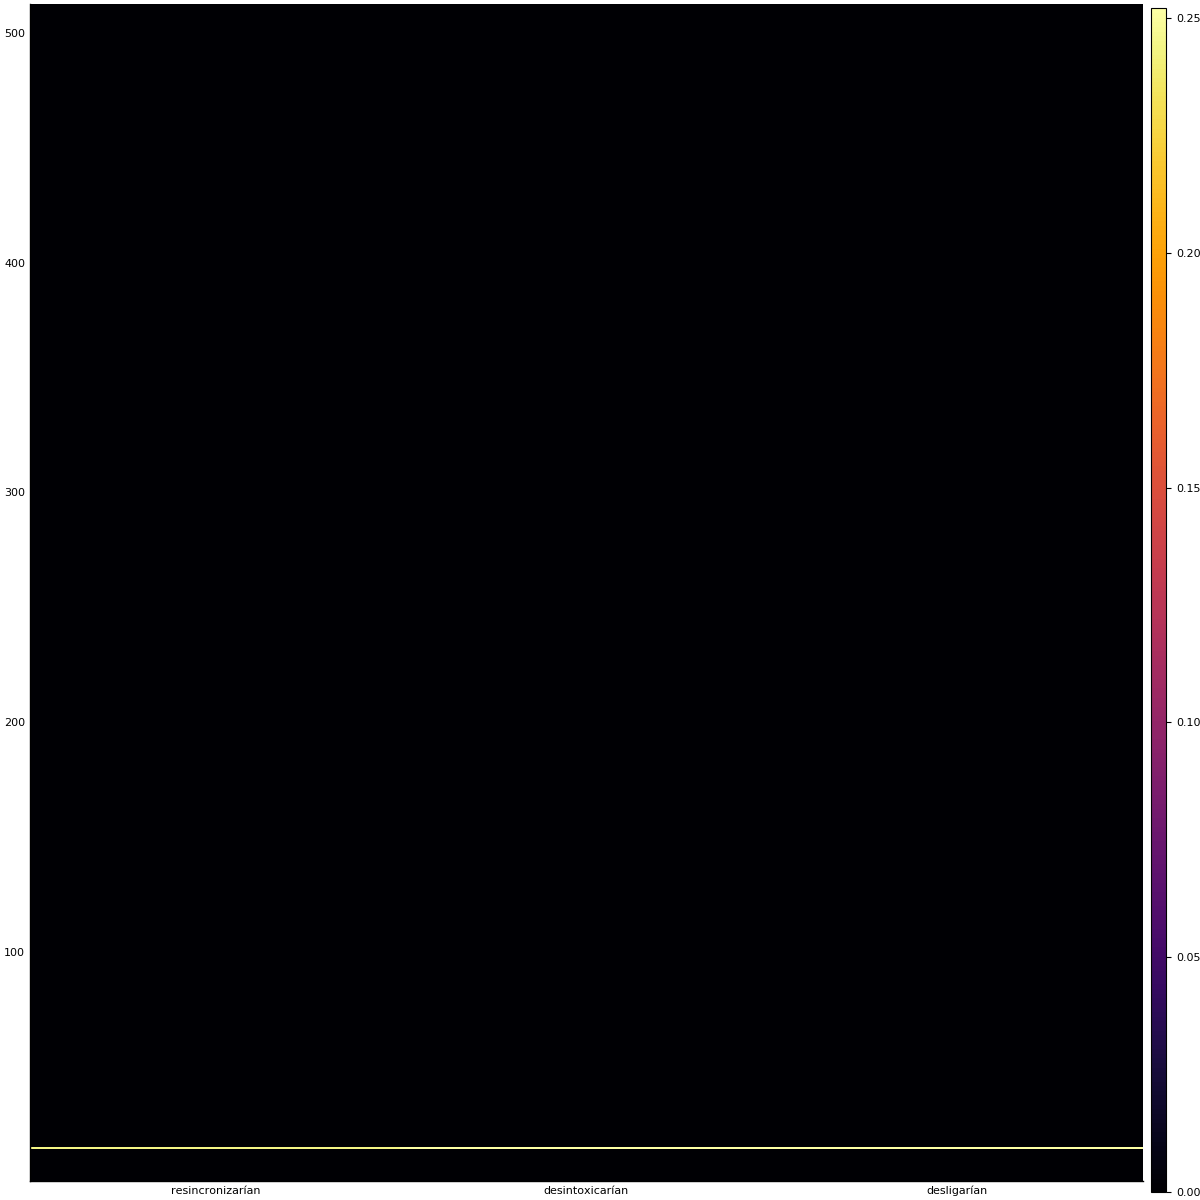

In [243]:
xs = e1
ys = 1:512
z = α1.ασ
heatmap(xs, ys, z;size=(1200,1200))

In [228]:
samples[findall([s ∈ trainsfs for s in samples])]

1903-element Array{String,1}:
 "paleaba"          
 "derritieron"      
 "envolvía"         
 "tipificasen"      
 "pilló"            
 "malentenderá"     
 "llaveemos"        
 "equivaldría"      
 "idearen"          
 "capitanea"        
 "rayó"             
 "ladeabais"        
 "prodigases"       
 "confortas"        
 "apasionases"      
 "descoceréis"      
 "vivificareis"     
 "abatata"          
 "no inmortalicemos"
 "mezclará"         
 "pellizca"         
 "despiezaran"      
 "alongarás"        
 ⋮                  
 "crujiendo"        
 "pregúntese"       
 "significaren"     
 "controlamos"      
 "orbitaréis"       
 "refrigeraba"      
 "pegáis"           
 "acantorares"      
 "escoplee"         
 "buceares"         
 "olfatearan"       
 "calificases"      
 "no viciemos"      
 "no piropeemos"    
 "plagaba"          
 "desalojó"         
 "asestara"         
 "veneró"           
 "transfirieres"    
 "barbarizadas"     
 "no barequeemos"   
 "recamarás"        

In [229]:
samples[findall([s ∈ testsfs for s in samples])]

4-element Array{String,1}:
 "balbuciera" 
 "aplomamos"  
 "amaitinad"  
 "retradujere"

In [66]:
samples[findall([s ∉ testsfs && s ∉ trainsfs for s in samples])]

2827-element Array{String,1}:
 "bufetearon"      
 "vadearían"       
 "desacatarais"    
 "encansaré"       
 "dute"            
 "plebisdis"       
 "empollan"        
 "estrapiaran"     
 "desnutriría"     
 "posifican"       
 "no desluemas"    
 "venteaba"        
 "conmemos"        
 "ecursionen"      
 "despepitases"    
 "os apoyaríais"   
 "magnifique"      
 "enjaularían"     
 "amarsaría"       
 "eletaríais"      
 "ajustares"       
 "flejanes"        
 "encureáremos"    
 ⋮                 
 "occidentalizamos"
 "descontinuado"   
 "vibroclamaría"   
 "despepásemos"    
 "no hundamos"     
 "jerandará"       
 "alfombaré"       
 "no lactemos"     
 "inmiturba"       
 "destrazamos"     
 "felizca"         
 "reconsideras"    
 "despeloter"      
 "abetunara"       
 "docarías"        
 "denunciamos"     
 "picada"          
 "desembecinaseis" 
 "recrudieras"     
 "esnifada"        
 "autopestundamos" 
 "no anociemos"    

In [67]:
samples2 = unique(sample(morph, vocab, edata; N=10000, useprior=false))

6470-element Array{String,1}:
 "malentenderá"      
 "desolle"           
 "erradiquen"        
 "superviviese"      
 "enrancias"         
 "no tomes"          
 "sobrecaliento"     
 "derritieron"       
 "atragantáramos"    
 "grincheare"        
 "desestabilizáremos"
 "rebautiza"         
 "refanfinflares"    
 "universalicé"      
 "desluzcamos"       
 "destoque"          
 "entumeciesen"      
 "cojoreásemos"      
 "licerare"          
 "terraplenan"       
 "informaban"        
 "crujieseis"        
 "dirminaría"        
 ⋮                   
 "no ó"              
 "colisione"         
 "atragantearás"     
 "llegaríais"        
 "hendía"            
 "cernear"           
 "fajado"            
 "culturemos"        
 "tiznada"           
 "asumiría"          
 "hiparás"           
 "trastorsado"       
 "castigamos"        
 "jerar"             
 "chocado"           
 "galvees"           
 "ardullarías"       
 "choque"            
 "se despedidos"     
 "yultamos"          
 "

In [68]:
samples2[findall([s ∈ trainsfs for s in samples2])]

2334-element Array{String,1}:
 "malentenderá"      
 "desolle"           
 "erradiquen"        
 "superviviese"      
 "enrancias"         
 "no tomes"          
 "sobrecaliento"     
 "derritieron"       
 "atragantáramos"    
 "desestabilizáremos"
 "rebautiza"         
 "refanfinflares"    
 "universalicé"      
 "desluzcamos"       
 "destoque"          
 "terraplenan"       
 "contagiabais"      
 "aliviara"          
 "remedaría"         
 "parlamentaba"      
 "elucubro"          
 "leuden"            
 "incriminando"      
 ⋮                   
 "añejaron"          
 "fastidiaron"       
 "laboraban"         
 "ahijáis"           
 "achantará"         
 "privemos"          
 "orinamos"          
 "carburizaron"      
 "se acomodaran"     
 "crepitásemos"      
 "nevisca"           
 "divagáremos"       
 "repostado"         
 "no fotocopien"     
 "martillé"          
 "colisione"         
 "hendía"            
 "culturemos"        
 "asumiría"          
 "castigamos"        
 "

In [69]:
samples2[findall([s ∈ testsfs for s in samples2])]

9-element Array{String,1}:
 "mostremos"   
 "aplomamos"   
 "agrada"      
 "cumplimos"   
 "vallaríais"  
 "caminaba"    
 "raparon"     
 "interpondría"
 "sonrosare"   